# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

<a id="1"></a>
## 1. Откройте и изучите файл

In [ ]:
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [ ]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Корреляционный анализ факторов

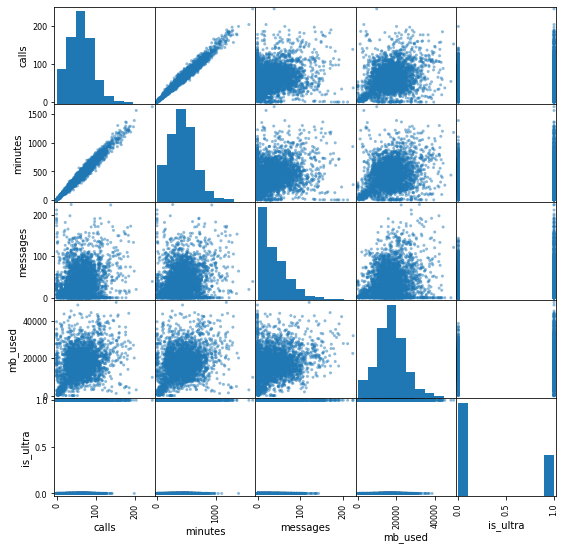

In [ ]:
import matplotlib.pyplot as plt 
pd.plotting.scatter_matrix(df, figsize=(9, 9)) 
plt.show()

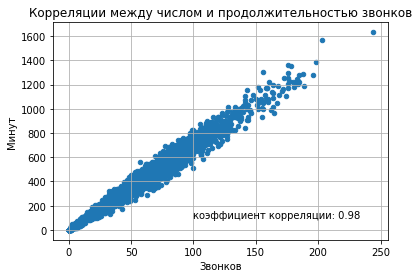

In [ ]:
df.plot(x='calls', y='minutes', kind='scatter', grid=True) 
plt.text(100, 100, 'коэффициент корреляции: ' + str(round(df['calls'].corr(df['minutes']), 2)))
plt.title("Корреляции между числом и продолжительностью звонков")
plt.ylabel("Минут")
plt.xlabel("Звонков")
plt.show()

Между количеством звонков и продолжительностью существует практически полная положительная связь. r<sub>xy</sub> = 0.98  
Избавимся от лишних данных

In [ ]:
df.drop(['calls'], axis='columns', inplace=True)

### Вывод
Избавились от лишнего признака

<a id="2"></a>
## 2. Разбейте данные на выборки

<a id="21"></a>
### Разобъем выборки на признаки и целевой признак

In [ ]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

<a id="22"></a>
### Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [ ]:
from sklearn.model_selection import train_test_split # импорт функции деления датасета

In [ ]:
features_train, features_part, target_train, target_part = train_test_split(features, target, test_size=0.30, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_part, target_part, test_size=0.5, random_state=12345)

Размер новых выборок

In [ ]:
print(features_train.shape, features_valid.shape, features_test.shape, target_train.shape,  target_valid.shape, target_test.shape)

(2249, 3) (482, 3) (483, 3) (2249,) (482,) (483,)


### Вывод
Мы разделили тестовую, тренировочную выборку и валидационную на признаки(features) и целевой признак(target).

<a id="3"></a>
## 3. Исследуйте модели

<a id="31"></a>
### Обучим модель Дерево Решений и проверим разные глубины

In [ ]:
#метод дерева принятия решений
from sklearn.tree import DecisionTreeClassifier
#метод оценки доли правильных ответов
from sklearn.metrics import accuracy_score

In [ ]:
dd = dict() #словарь для пары: глубина, погрешность
for depth in range(1, 6): #заранее в большем диапозоне получил 3, и 4
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    dd[depth] = accuracy
    print('depth:', depth, '     accuracy:', accuracy)
print('лучшая модель глубиной', [key for key in dd if dd[key] == max(dd.values())])

depth: 1      accuracy: 0.7510373443983402
depth: 2      accuracy: 0.7800829875518672
depth: 3      accuracy: 0.7863070539419087
depth: 4      accuracy: 0.7863070539419087
depth: 5      accuracy: 0.7697095435684648
лучшая модель глубиной [3, 4]


<a id="32"></a>
### Обучим модель алгоритм Случайный лес + различная глубина

In [ ]:
#импортируем метод случайного леса
from sklearn.ensemble import RandomForestClassifier


In [ ]:
accur=0
est=0
dep=0
for estim in range(2,15, 3): #я уже просчитал в большем диапозоне, не буду грузить сервер.
    for depth in range(11,15):
        model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
        if accuracy > accur:
            accur=accuracy
            est=estim
            dep=depth
print("n_estimators:", est, "depth:", dep, "accuracy", accur)

n_estimators: 5 depth: 13 accuracy 0.8049792531120332


<a id="33"></a>
### Обучим модель алгоритмом логистической регрессии

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model =  LogisticRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print('accuracy:', accuracy)


accuracy: 0.6908713692946058


### Вывод
- Обучили дерево принятия решений, лучшее с глубиной 13
- Обучили модель случайного леса с подбором глубины. Лучшее с количеством оценщиков 24, глубиной 10. Лучший результат.
- Обучили модель логистической регрессии и получили метрики хуже остальных моделей.

<a id="4"></a>
## 4. Проверьте модель на тестовой выборке

Объединение тренировочной и валидной выборки


In [ ]:
features_train=pd.concat([features_train, features_valid])
target_train=pd.concat([target_train, target_valid])

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=5, max_depth=13)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('accuracy =','{:.4f}'.format(accuracy))

accuracy = 0.7805


<a id="5"></a>
## 5. (бонус) Проверьте модели на адекватность

### Простейшая модель, которая всегда предсказывает наиболее часто встречающийся класс

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_train, target_train)

0.6931526913218601

Простейшая модель ошибается в 30%, выбранная в 21%

### Вывод
Выбранная модель лучше, чем простейшая модель, удалось достичь accuracy не меньше 0.75, проверка на адекватность пройдена.